<a href="https://colab.research.google.com/github/dayananikol/dl_models/blob/main/MODEL5_bentory_wUnknown11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
import tensorflow as tf
import os

# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


Found 3632 images belonging to 10 classes.
Found 907 images belonging to 10 classes.
Found 200 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 550 images belonging to 11 classes.


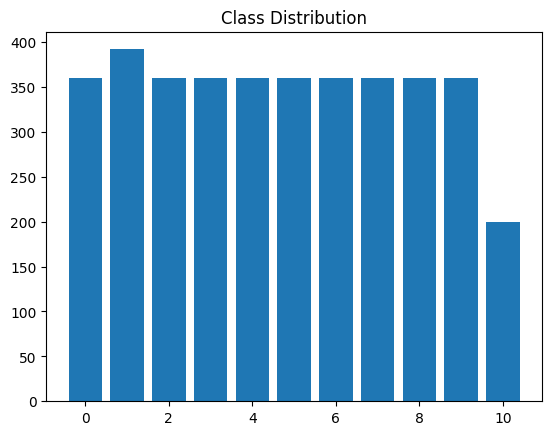

Class Weights: {0: np.float64(0.9676767676767677), 1: np.float64(0.8886827458256029), 2: np.float64(0.9676767676767677), 3: np.float64(0.9676767676767677), 4: np.float64(0.9676767676767677), 5: np.float64(0.9676767676767677), 6: np.float64(0.9676767676767677), 7: np.float64(0.9676767676767677), 8: np.float64(0.9676767676767677), 9: np.float64(0.9676767676767677), 10: np.float64(1.7418181818181817)}
Known classes: {'Bear Brand': 0, 'C2': 1, 'Datu Puti Suka': 2, 'Datu Puti Toyo': 3, 'Ligo': 4, 'Magic Sarap': 5, 'Pancit Canton Kalamansi': 6, 'Safeguard': 7, 'Surf Powder': 8, 'V Cut': 9}
Unknown classes: {'Unknown': 0}


In [ ]:
# Set paths
known_dir = '/content/drive/MyDrive/bentory_dataset/final_ready_dataset/Known'
unknown_dir = '/content/drive/MyDrive/bentory_dataset/final_ready_dataset/Unknown'
test_dir = '/content/drive/MyDrive/bentory_dataset/final_ready_dataset_test'


# Define image size and batch
IMG_SIZE = 224
BATCH_SIZE = 32

def custom_preprocess(img):
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_brightness(img, 0.1)
    return img

datagen_known = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2,
    fill_mode='nearest',
    preprocessing_function=custom_preprocess
)

datagen_unknown = ImageDataGenerator(
   rescale=1./255,
   rotation_range=15,
   width_shift_range=0.1,
   height_shift_range=0.1,
   zoom_range=0.1,
   horizontal_flip=True,
   validation_split=0.2
)



# Known class generators
known_train = datagen_known.flow_from_directory(
    known_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE // 2,
    class_mode='sparse',
    subset='training',
    seed=42
)

known_val = datagen_known.flow_from_directory(
    known_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE // 2,
    class_mode='sparse',
    subset='validation',
    seed=42
)

# Unknown class generators
unknown_train = datagen_unknown.flow_from_directory(
    unknown_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE // 2,
    class_mode='sparse',
    subset='training',
    seed=42
)

unknown_val = datagen_unknown.flow_from_directory(
    unknown_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE // 2,
    class_mode='sparse',
    subset='validation',
    seed=42
)


# Test generator (no augmentation, no split)
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

num_output_classes = known_train.num_classes + unknown_train.num_classes

def combined_generator_sparse(gen1, gen2, class_weights_dict):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)

        # Shift unknown class indices
        y2 = y2 + known_train.num_classes  # Keep y1 and y2 as ints

        x = np.concatenate([x1, x2], axis=0)
        y = np.concatenate([y1, y2], axis=0)

        # Calculate sample weights based on class weights
        sample_weights = np.array([class_weights_dict[int(label)] for label in y])

        # Shuffle
        idx = np.random.permutation(len(x))
        yield x[idx], y[idx], sample_weights[idx] # Yield x, y, and sample_weights

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import collections
import matplotlib.pyplot as plt

y_train = np.concatenate([known_train.classes, unknown_train.classes + known_train.num_classes])
class_counts = collections.Counter(y_train)
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.show()

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)


# Re-create the generators with the class_weights dictionary
train_gen = combined_generator_sparse(known_train, unknown_train, class_weights)
val_gen = combined_generator_sparse(known_val, unknown_val, class_weights)


train_steps = max(len(known_train), len(unknown_train))
val_steps = max(len(known_val), len(unknown_val))

print("Known classes:", known_train.class_indices)
print("Unknown classes:", unknown_train.class_indices)


In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization

num_output_classes = known_train.num_classes + unknown_train.num_classes

model = tf.keras.models.Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(64, (3,3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2,2),
    Dropout(0.2),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_output_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# Step 4: Model checkpoint
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

# Step 5: Compile model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Step 6: Train model with class weights
model.fit(
    train_gen,
    validation_data=val_gen,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=15,
    callbacks=[checkpoint]
)


Epoch 1/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4122 - loss: 15.1067
Epoch 1: val_loss improved from inf to 4.81844, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1950s 9s/step - accuracy: 0.4124 - loss: 15.0650 - val_accuracy: 0.4412 - val_loss: 4.8184
Epoch 2/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5139 - loss: 1.6940
Epoch 2: val_loss improved from 4.81844 to 4.34221, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1658s 7s/step - accuracy: 0.5139 - loss: 1.6937 - val_accuracy: 0.4412 - val_loss: 4.3422
Epoch 3/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5351 - loss: 1.4431
Epoch 3: val_loss improved from 4.34221 to 2.56442, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1645s 7s/step - accuracy: 0.5351 - loss: 1.4429 - val_accuracy: 0.4899 - val_loss: 2.5644
Epoch 4/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5592 - loss: 1.2789
Epoch 4: val_loss improved from 2.56442 to 1.59704, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1634s 7s/step - accuracy: 0.5593 - loss: 1.2789 - val_accuracy: 0.5404 - val_loss: 1.5970
Epoch 5/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5838 - loss: 1.2185
Epoch 5: val_loss did not improve from 1.59704
227/227 ━━━━━━━━━━━━━━━━━━━━ 1628s 7s/step - accuracy: 0.5838 - loss: 1.2183 - val_accuracy: 0.5145 - val_loss: 1.8844
Epoch 6/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6052 - loss: 1.1018
Epoch 6: val_loss improved from 1.59704 to 1.32023, saving model to best_model.h5


227/227 ━━━━━━━━━━━━━━━━━━━━ 1642s 7s/step - accuracy: 0.6052 - loss: 1.1018 - val_accuracy: 0.5823 - val_loss: 1.3202
Epoch 7/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6142 - loss: 1.0713
Epoch 7: val_loss did not improve from 1.32023
227/227 ━━━━━━━━━━━━━━━━━━━━ 1637s 7s/step - accuracy: 0.6142 - loss: 1.0712 - val_accuracy: 0.5693 - val_loss: 2.5014
Epoch 8/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6603 - loss: 0.9623
Epoch 8: val_loss did not improve from 1.32023
227/227 ━━━━━━━━━━━━━━━━━━━━ 1644s 7s/step - accuracy: 0.6603 - loss: 0.9624 - val_accuracy: 0.6032 - val_loss: 1.3514
Epoch 9/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6628 - loss: 0.9694
Epoch 9: val_loss did not improve from 1.32023
227/227 ━━━━━━━━━━━━━━━━━━━━ 1639s 7s/step - accuracy: 0.6628 - loss: 0.9693 - val_accuracy: 0.6192 - val_loss: 1.9305
Epoch 10/15
227/227 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6862 - loss: 0.9155
Epoch 10: val_loss did not improve from 1.

227/227 ━━━━━━━━━━━━━━━━━━━━ 1630s 7s/step - accuracy: 0.7403 - loss: 0.7712 - val_accuracy: 0.7208 - val_loss: 1.2258


In [ ]:
loss, accuracy = model.evaluate(test_gen)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 159s 9s/step - accuracy: 0.8026 - loss: 1.5953
Test Loss: 3.9005677700042725
Test Accuracy: 0.6690909266471863


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions
predictions = model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Evaluate the model
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

18/18 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step
Classification Report:
                         precision    recall  f1-score   support

             Bear Brand       0.96      1.00      0.98        50
                     C2       0.94      0.88      0.91        50
         Datu Puti Suka       0.93      0.76      0.84        50
         Datu Puti Toyo       1.00      0.88      0.94        50
                   Ligo       1.00      0.50      0.67        50
            Magic Sarap       1.00      0.70      0.82        50
Pancit Canton Kalamansi       1.00      0.50      0.67        50
              Safeguard       0.98      0.90      0.94        50
            Surf Powder       0.90      0.92      0.91        50
                Unknown       0.00      0.00      0.00        50
                  V Cut       0.11      0.32      0.16        50

               accuracy                           0.67       550
              macro avg       0.80      0.67      0.71       550
           weighted avg   

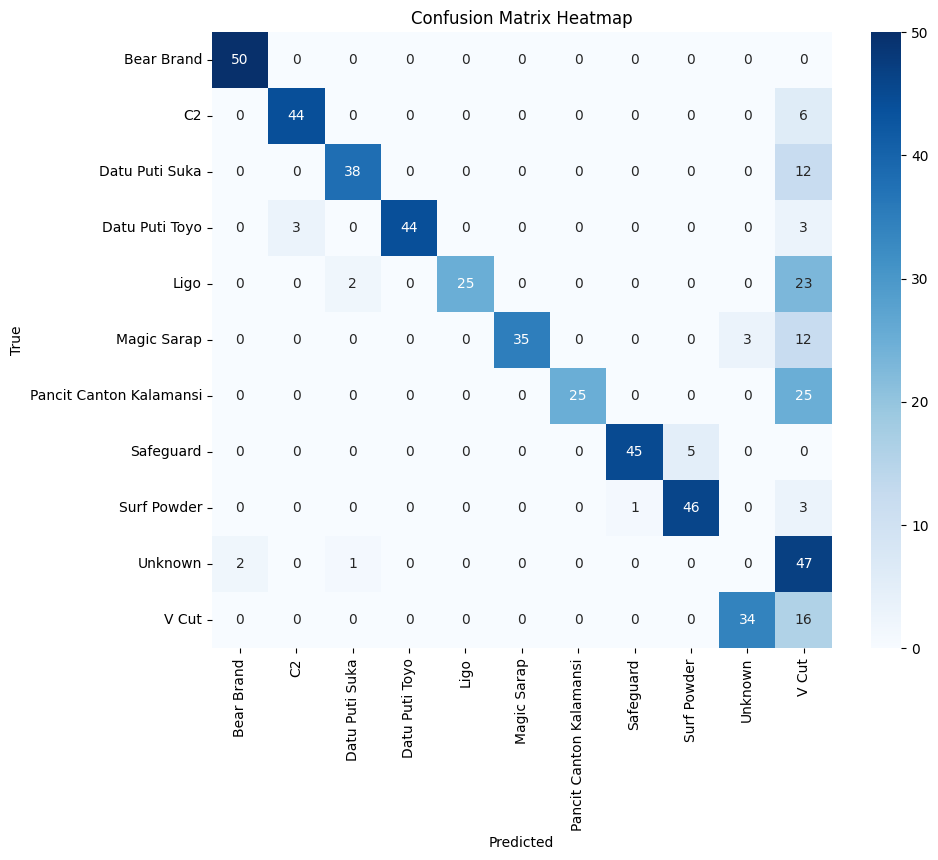

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Use the true_classes and predicted_classes calculated earlier
true_labels = true_classes
pred_labels = predicted_classes

# Create confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
class_names = list(test_gen.class_indices.keys()) # Use class names from test_gen

# Plot using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

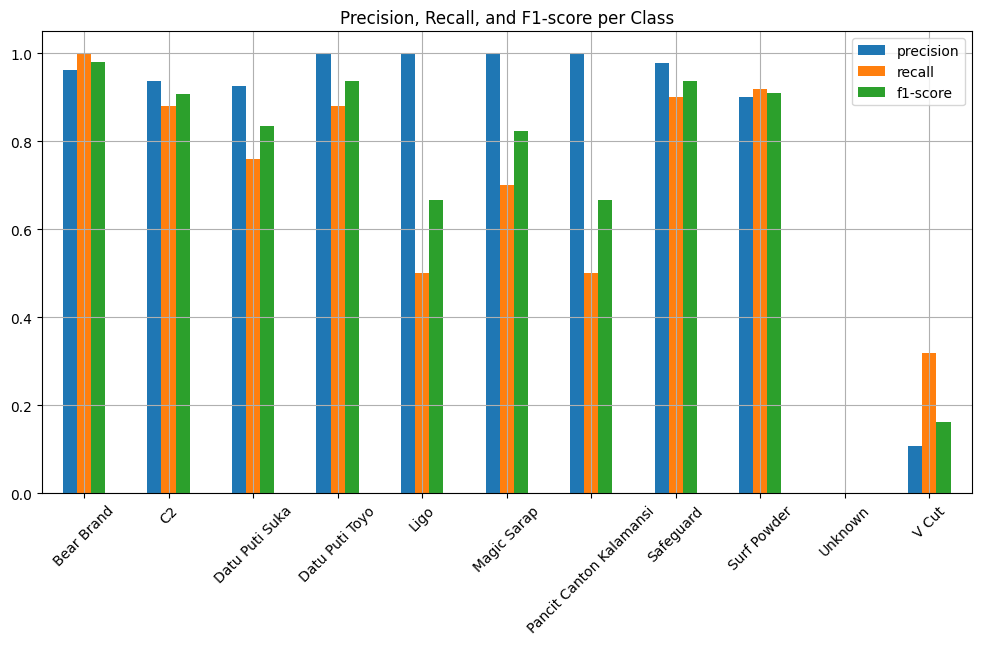

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Get classification report as dictionary
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plot
df_report.iloc[:-3][['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(12, 6))
plt.title('Precision, Recall, and F1-score per Class')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step


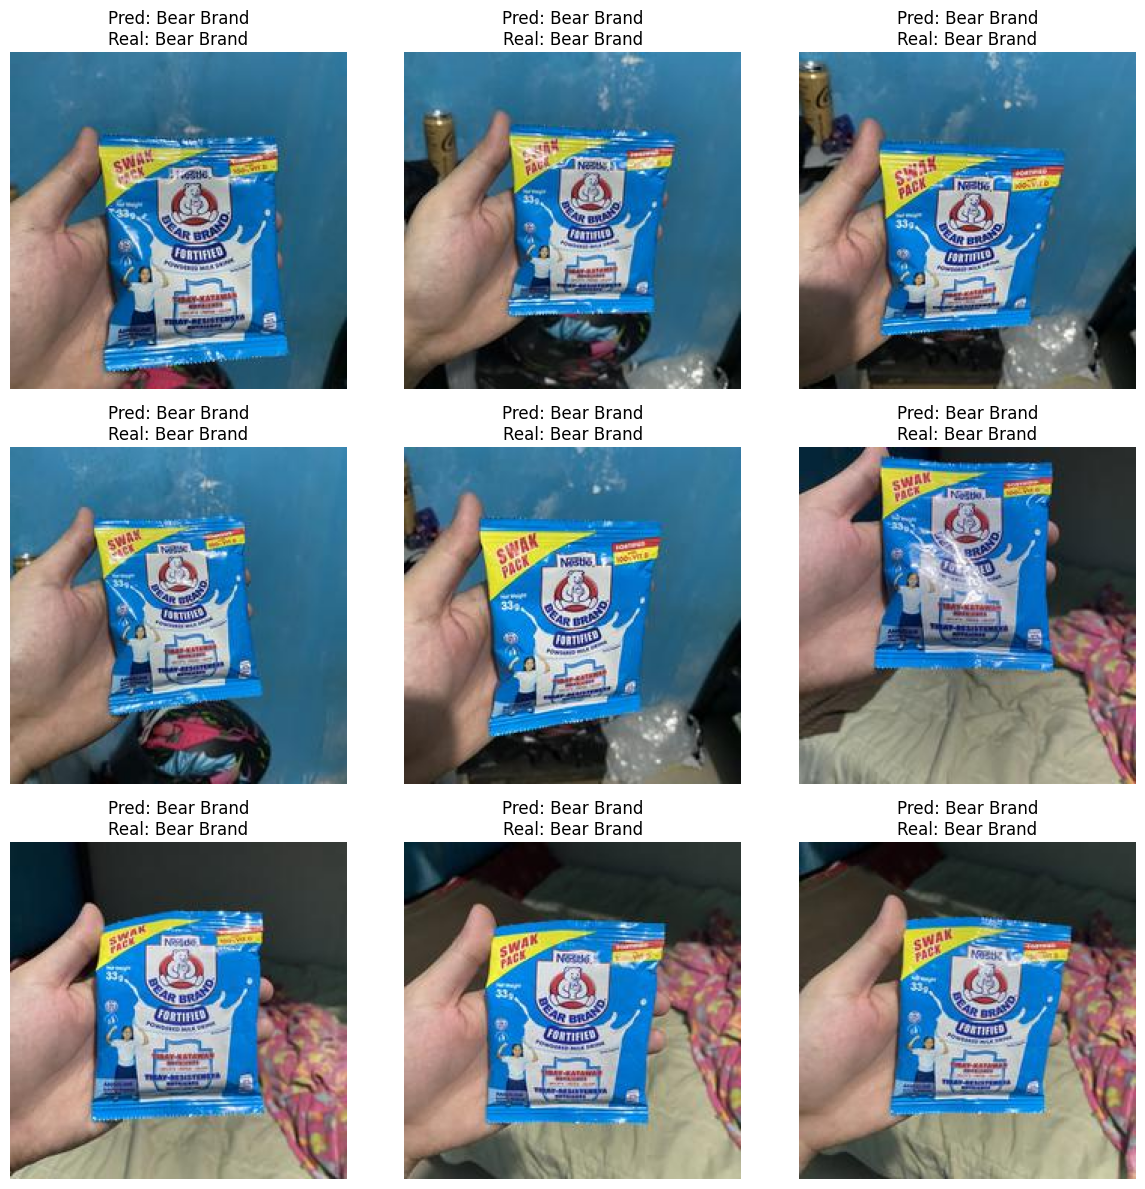

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get a batch of test images and labels
images, labels = next(test_gen)

# Get class names and create index-to-label mapping
class_indices = test_gen.class_indices
class_names = list(class_indices.keys())
idx_to_label = {v: k for k, v in class_indices.items()} # Create the mapping

# Select the first N images
num_images_to_show = 9
selected_images = images[:num_images_to_show]
selected_labels = labels[:num_images_to_show]
# Note: test_gen gives sparse labels (integers), so we don't need np.argmax here
true_class_names = [class_names[int(label)] for label in selected_labels]


# Get predictions on just the selected batch
preds = model.predict(selected_images)
predicted_class_indices = tf.argmax(preds, axis=1).numpy()
predicted_labels = [idx_to_label[i] for i in predicted_class_indices]

# Plot images with predicted and true labels
plt.figure(figsize=(12, 12))
for i in range(num_images_to_show):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(selected_images[i])
    plt.title(f"Pred: {predicted_labels[i]}\nReal: {true_class_names[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf

h5_model_path = 'best_model.h5'

model = tf.keras.models.load_model(h5_model_path)

    # Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

drive_save_path = '/content/drive/MyDrive/bentory_dataset//best_model.tflite' # <--- Change 'your_model_folder'

# Save the TensorFlow Lite model to a file
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

# import tensorflow as tf
# import os

# # Path to your trained .h5 model file
# h5_model_path = 'best_model.h5'

# # Load the model from the .h5 file
# model = tf.keras.models.load_model(h5_model_path)

# # Define a directory to save the model in the SavedModel format
# saved_model_dir = 'saved_model_directory'

# # Save the model in the SavedModel format using model.export()
# # This is the correct method for exporting to the SavedModel format
# model.export(saved_model_dir)

# # Now use the directory path with the TFLiteConverter
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)

# # Optional: Apply optimization (reduce size)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Convert the model
# tflite_model = converter.convert()

# # Save to file
# with open('model.tflite', 'wb') as f:
#     f.write(tflite_model)

# print("✅ Model successfully converted to model.tflite")

Saved artifact at '/tmp/tmputv8tb3b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  132562354031888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354031120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354030736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354029776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354036880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354038416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354031504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354034768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354036688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562354032848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13256235403400

In [ ]:
h5_model_path = 'best_model.h5'

model = tf.keras.models.load_model(h5_model_path)

    # Convert the Keras model to a TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

drive_save_path = '/content/drive/MyDrive/bentory_dataset/best_model.tflite' # <--- Change 'your_model_folder'

# Save the TensorFlow Lite model to a file
with open('best_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmplnxaachd'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 11), dtype=tf.float32, name=None)
Captures:
  132562355647312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355645584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355645968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355645776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355646160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355645008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355635984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355643088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355646544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132562355642512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13256235564539